# MNIST

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # Package name: torch (for pip), pytorch (for conda)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]
    
#Some methods for evaluating results
def get_confusion_matrix(y_pred, y_true, n_classes):
    assert len(y_pred) == len(y_true)
    results = np.zeros(shape=(n_classes, n_classes))
    for i in range(len(y_pred)):
        results[y_pred[i], y_true[i]] += 1
    return results
    
def precision(y_pred, y_true, n_classes):
    precision = np.zeros(shape=n_classes)
    confusion_matrix = get_confusion_matrix(y_pred, y_true, n_classes)
    for i in range(n_classes):
        sum_of_row = confusion_matrix[i].sum()
        if confusion_matrix[i, i] != 0:
            precision[i] = confusion_matrix[i, i] / sum_of_row
    return precision

def recall(y_pred, y_true, n_classes):
    recall = np.zeros(shape=n_classes)
    confusion_matrix = get_confusion_matrix(y_pred, y_true, n_classes)
    for i in range(n_classes):
        sum_of_column = confusion_matrix[:,i].sum()
        if confusion_matrix[i, i] != 0:
            recall[i] = confusion_matrix[i, i] / sum_of_column
    return recall

def f1score(y_pred, y_true, n_classes):
    p = precision(y_pred, y_true, n_classes)
    r = recall(y_pred, y_true, n_classes)
    f1 = np.zeros(shape=n_classes)
    for i in range(n_classes):
        if r[i] + p[i] != 0:
            f1[i] = 2 * p[i] * r[i] / (r[i] + p[i])
    return f1

## Prepare Data

In [2]:
import torchvision.datasets as datasets

n_classes = 10
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
print(mnist_trainset)
print(mnist_testset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


C:\Users\robin\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
def to_rgb(x_grey: torch.Tensor) -> torch.Tensor:
    helper = torch.unsqueeze(x_grey, 1)
    return helper.repeat(1, 3, 1, 1).float()

X_train_grey = mnist_trainset.train_data
X_train = to_rgb(X_train_grey)
X_test_grey = mnist_testset.test_data
X_test = to_rgb(X_test_grey)
y_train = mnist_trainset.train_labels
y_test = mnist_testset.test_labels
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

C:\Users\robin\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


X_train: torch.Size([60000, 3, 28, 28])
X_test: torch.Size([10000, 3, 28, 28])
y_train: torch.Size([60000])
y_test: torch.Size([10000])


C:\Users\robin\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\robin\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\robin\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Training

In [4]:
from torchvision import models

model = models.resnet18(pretrained=False) # set model here
in_ftr = model.fc.in_features
out_ftr = n_classes
model.fc = nn.Linear(in_ftr,out_ftr,bias=True)
    
dataset_train = BasicDataset(X_train, y_train)
dataset_test = BasicDataset(X_test, y_test)

Check specs for GPU-based training.

In [5]:
print('cuda available:', torch.cuda.is_available())
print('cuda device name:', torch.cuda.get_device_name())
print('cuda device id', torch.cuda.current_device())

cuda available: True
cuda device name: NVIDIA GeForce 940MX
cuda device id 0


Move model and data to GPU.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train.to(device)
print('worked?', X_train.to(device).is_cuda)

worked? True


In [7]:
yhat = torch.argmax(model.forward(X_train[:5].to(device)), dim=1)
print(yhat)
print(y_train[:5])
correct = (yhat == y_train[:5].to(device)).float().sum()
print(correct)

C:\Users\robin\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([9, 8, 2, 6, 6], device='cuda:0')
tensor([5, 0, 4, 1, 9])
tensor(0., device='cuda:0')


In [8]:
def get_accuracy(model, dataset):
    data_loader = data.DataLoader(dataset=dataset, batch_size=100, shuffle=True, drop_last=True)
    correct = 0
    for batch in data_loader:
        yhat = torch.argmax(model.forward(batch['X'].float().to(device)), dim=1)
        y = batch['y'].long().to(device)
        correct += (yhat == y).float().sum().item()
    return correct / len(dataset)

In [9]:
print(get_accuracy(model, dataset_test))

0.0977


In [10]:
def train_model(model, dataset, validation_set, base_lr=0.01, max_lr=0.01, batch_size=64, epochs=1, 
                f_opt=optim.SGD, f_loss=F.cross_entropy):
    
    optimizer = f_opt(model.parameters(), lr=base_lr)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr)
    lr_history = []
    validation_accuracy = []
    epoch_losses = []
    validation_losses = []

    for epoch in range(epochs):
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_data_loader = data.DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=True, drop_last=True)
        
        epoch_loss = 0.0 
        for batch in data_loader:
            model.zero_grad()
            yhat = model.forward(batch['X'].float().to(device))
            batch_loss = f_loss(yhat, batch['y'].long().to(device))
            epoch_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()
            scheduler.step()
            #validation_accuracy.append(get_accuracy(model, validation_set))
            lr_history.append(scheduler.get_last_lr())
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss} - LR: {scheduler.get_last_lr()}')
        epoch_losses.append(epoch_loss)
        
        # Calculate validation loss
        validation_loss = 0.0
        for batch in val_data_loader:
            yhat = model.forward(batch['X'].float().to(device))
            batch_loss = f_loss(yhat, batch['y'].long().to(device))
            validation_loss += batch_loss.item()
        validation_losses.append(validation_loss)
        
    return epoch_losses, validation_losses, validation_accuracy, lr_history

In [11]:
base_lr = 0.01
max_lr = 0.1
batch_size = 100
epochs = 10
f_opt=optim.SGD
f_loss=F.cross_entropy

training_loss, validation_loss, validation_accuracy, lr_history = train_model(model.to(device), dataset_train, dataset_test,
                                                                              base_lr, max_lr, batch_size, epochs,
                                                                              f_opt, f_loss)

Epoch 1/10 - Loss: 87.35900875367224 - LR: [0.036999999999999984]
Epoch 2/10 - Loss: 38.36066629609559 - LR: [0.06400000000000002]
Epoch 3/10 - Loss: 25.29871120574535 - LR: [0.091]
Epoch 4/10 - Loss: 19.65057417517528 - LR: [0.08199999999999999]
Epoch 5/10 - Loss: 11.665653980664501 - LR: [0.05500000000000001]
Epoch 6/10 - Loss: 5.994310900394339 - LR: [0.028000000000000018]
Epoch 7/10 - Loss: 2.496631502002856 - LR: [0.01899999999999997]
Epoch 8/10 - Loss: 2.602100965395948 - LR: [0.04600000000000004]
Epoch 9/10 - Loss: 4.731824175716611 - LR: [0.07300000000000002]
Epoch 10/10 - Loss: 7.172792354143894 - LR: [0.1]


0.0016666666666666668
0.01


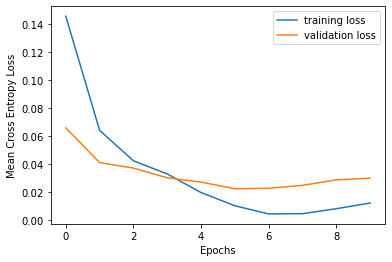

In [12]:
print(batch_size / len(X_train))
print(batch_size / len(X_test))

plt.plot(np.array(training_loss) * batch_size / len(X_train), label='training loss')
plt.plot(np.array(validation_loss) * batch_size / len(X_test), label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Cross Entropy Loss')
#plt.ylim(0.0, 10)
plt.legend()

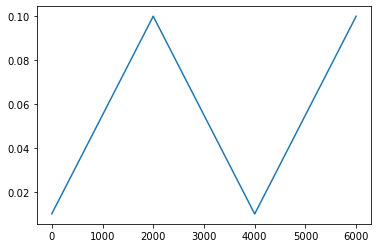

In [13]:
plt.plot(lr_history)

In [14]:
import csv
from google.colab import files

with open('train_loss', 'w') as f:
    write = csv.writer(f)
    write.writerow(training_loss)

with open('val_loss', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(validation_loss)

with open('val_accuracy', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(validation_accuracy)
    
with open('lr_history', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(lr_history)

files.download('train_loss')
files.download('val_loss')
files.download('val_accuracy')
files.download('lr_history')

ModuleNotFoundError: No module named 'google'